In [56]:
from __future__ import division
%pylab inline
import pandas as pd
import os
import json
from collections import defaultdict, Counter
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/Cellar/ipython/7.1.1/libexec/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [301]:
df_ip_asn = pd.read_pickle('results/df_ip_asn.pkl')
df_cdn = pd.read_pickle('results/df_cdn.pkl')
df_timing = pd.read_pickle('results/df_timing.pkl')

rank_to_site = df_ip_asn.set_index('rank')['site'].to_dict()

del df_ip_asn, df_cdn

# TIMING CLEANUP AND ANALYSIS

#### Get avg redirect timings per site in case we allowed redirects to the 200 OK page

In [58]:
from calculate_timings import calculate_sizes, calculate_timings 

# messed up timings due to redirection - don't work with this directly
redirect_data = pd.read_json("output/curl-timing-data-reorder-count100-sites500.json")
calculate_timings(redirect_data)
calculate_sizes(redirect_data)

df_timing_redirect = redirect_data[redirect_data['response_code']==200][['rank', 'size_dw', 'time_redirect', 't_rx', 'time_total']]


In [59]:
# check if time_redirect > 0
print( len(df_timing[df_timing["response_code"]!="000"]) )
print( len(df_timing[(df_timing["response_code"]!="000") & (df_timing["time_redirect"]>0.0)]) )
print( len(df_timing_redirect) )
print( len(df_timing_redirect[ df_timing_redirect['time_redirect'] > 0 ]) )

# calculate mean time_redirect per site 
mean_redirect_per_site = df_timing_redirect.groupby('rank').mean()

42902
0
37470
12537


# Clean up
- 50000 requests:
    - 7098 failed with response code 0, 42902 passed
    - 23898 directly gave webpage (response_code 200)
    - 16090 redirect with 301/302 (permanent and temporary redirect) 7k+ each
    - 2266 forbidden and could not be fulfilled possibly due to too many requests detected from our IP/script
    - 648 unavailable service maybe due to bad proxy

In [60]:
df_fail = df_timing[df_timing['response_code'] == "000"]
df_pass = df_timing[df_timing['response_code']!= "000"]

In [61]:
len(df_fail), len(df_pass)

(7098, 42902)

In [62]:
df_pass.groupby('response_code')['rank'].count()

response_code
200    23898
301     7693
302     7923
303       96
307      378
403     1528
404      667
429       71
500       95
502       18
503      535
Name: rank, dtype: int64

In [10]:
print(7693 + 7923 + 96 + 378)
print(1528 + 667 + 71)
print(535 + 18 + 95)

16090
2266
648


### Google.* redirect behavior
- Only about first 20 requests have a 200 response for all google.* domains
- Suddenly all start redirecting to manual check page
- network reset occurs impacting all sites and we get a few more 200's in before page 302s again
- only impact google.* domains not youtube etc. that are also on the same ASN 

In [11]:
google = df_timing[df_timing['rank']==1]
youtube = df_timing[df_timing['rank']==2]
facebook = df_timing[df_timing['rank']==3]
googlein = df_timing[df_timing['rank']==12]

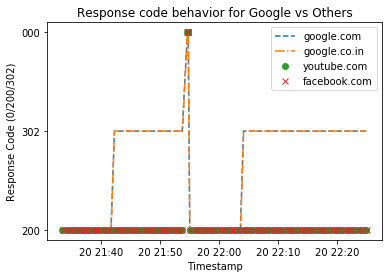

In [12]:
f,ax = subplots()
ax.plot( pd.to_datetime(google.timestamp, unit='s'), google['response_code'], label='google.com', linestyle='--')
ax.plot( pd.to_datetime(googlein.timestamp, unit='s'), googlein['response_code'], label='google.co.in', linestyle='-.')
ax.plot( pd.to_datetime(youtube.timestamp, unit='s'), youtube['response_code'], label='youtube.com', marker='o', linestyle='None')
ax.plot( pd.to_datetime(facebook.timestamp, unit='s'), facebook['response_code'], label='facebook.com', marker ='x', linestyle='None')
ax.legend(loc='best')
ax.set_title("Response code behavior for Google vs Others")
ax.set_xlabel('Timestamp')
ax.set_ylabel("Response Code (0/200/302)")
f.savefig('results/google_vs_others_response_code')


### Failure rate per domain
- 49 sites completely failed, i.e. all responses were 0, no data was downloaded
- 18 of 49 sites are those that were blocked by ISP and we could not get their host IP address. This includes porn related websites and some adware/malware domains.
- Of 31 sites, the chinese ones could be reached via browser (\*.tmall.com, china.com.cn). Certain domains were completely unaccessible (redd.it, twimg.com, cloudfront.net) possibly because they are servers catering to specific IPs/ports only. Certain others (bodelen.com, resentaticexhaus.info) are redirect viruses that send you to your browser's home page.
- After removing the 49 sites, we are left with 45100 requests of which only 2198 failed around the same time (around loop 40 of 100 requests/site). This may be due to a network failure, or a reset at the ISP. 
- Of all other 451 sites, only 1 site (rank 368 'youdao.com') received status code 0 for 72 requests. So we can use only 28 requests to estimate timings. All other sites had responses for more than 60 requests each.

In [13]:
df_timing['fail']= df_timing['response_code']=="000"

In [14]:
df_temp = df_timing.groupby(['rank', 'fail'])['response_code'].count().reset_index()
df_total_responses = df_temp.pivot(index='rank', columns='fail', values='response_code').fillna(0).reset_index()
df_total_responses['site'] = df_total_responses['rank'].map(rank_to_site)

In [15]:
df_all_fail = df_total_responses[ df_total_responses[False]==0 ]
print(len(df_all_fail))

49


In [16]:
df_filtered = df_timing[ ~df_timing['rank'].isin(df_all_fail['rank']) ]

print(len(df_filtered))
print(len(df_filtered['rank'].unique()))

df_filtered.groupby('response_code')['rank'].count()

45100
451


response_code
000     2198
200    23898
301     7693
302     7923
303       96
307      378
403     1528
404      667
429       71
500       95
502       18
503      535
Name: rank, dtype: int64

Total responses with status code 0 (Failed) =  2198
Total responses with status code 200 (OK) =  23898
Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) =  19004
Overall success rate = 0.5298891352549889


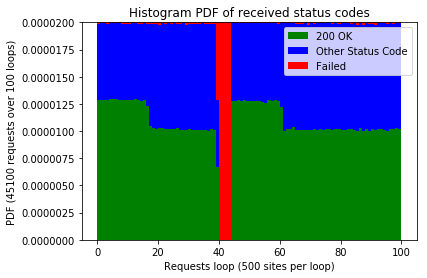

In [17]:
data0 = [int(d) for d in df_filtered[(df_filtered['response_code']=="000")]['response_code'].index ]
#x0,y0 = getCDF(data0)
data200 = [int(d) for d in df_filtered[(df_filtered['response_code']=="200")]['response_code'].index ]
#x200,y200 = getCDF(data200)
dataother = [int(d) for d in df_filtered[~(df_filtered['response_code'].isin(["000","200"]))]['response_code'].index ]
#xother,yother = getCDF(dataother)

print("Total responses with status code 0 (Failed) = ", len(data0))
print("Total responses with status code 200 (OK) = ", len(data200))
print("Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) = ", len(dataother))
print("Overall success rate = %s" %(len(data200)/len(df_filtered)))

f,ax = subplots()
ax.hist([data200,dataother,data0], 100, color=["green", "blue","red"], density = True, stacked=True)
ax.legend({'200 OK': "green", 'Other Status Code': "blue", 'Failed': "red"})
labels=[int(l/500) for l in ax.get_xticks().tolist()]
ax.set_xticklabels(labels)
ax.set_title("Histogram PDF of received status codes")
ax.set_xlabel("Requests loop (500 sites per loop)")
ax.set_ylabel("PDF (45100 requests over 100 loops)")
f.savefig("results/curl_requests_filtered_status_code_pdf_hist")

# Analyze df_passed
- remove all failures
- An overall avg across all 42902 valid responses shows:
    - 1.03s total load time (this includes sites that fully loaded with 200 OK response, and sites that were forbidden or redirected us). This does not include following redirection to the correct page (as seen on browsers).
    - overall average size downloaded is around 102 KB, while overall reception time is .25s, making the approx avg download speed for webpages ~3.25 Mbps. 
    - overall dns resolution and tcp handshake are quite fast (0.08s, 0.095s), but ssl negotiation takes 0.24s on avg.
    - overall average waiting time is surprisingly 0.37s, making it a major contribution to the total time. Even removing tcp handshake time (0.09s) from this implies that the server genuinely waits for around 0.3s on average across all valid responses.

In [18]:
df_pass = df_filtered[df_filtered['response_code']!="000"]

check = df_pass.groupby('rank')['response_code'].count()
check[ check<60 ]

rank
368    28
Name: response_code, dtype: int64

### Quick average of avg across sites

In [19]:
print(len(df_pass))

42902


In [20]:
#df_pass.groupby('rank').mean().mean()  # each site contributes once after grouping instead of overall avg

df_pass.mean()

response_code                  inf
size_request          7.762170e+01
size_upload           0.000000e+00
size_download         1.015417e+05
size_header           7.044556e+02
time_redirect         0.000000e+00
time_namelookup       8.042845e-02
time_connect          1.754896e-01
time_appconnect       4.156208e-01
time_pretransfer      4.157021e-01
time_starttransfer    7.867532e-01
time_total            1.033064e+00
rank                  2.513959e+02
timestamp             1.545343e+09
size_up               7.762170e+01
size_dw               1.022461e+05
t_dns                 8.042845e-02
t_tcp                 9.506114e-02
t_ssl                 2.401312e-01
ssl_flag              1.000000e+00
t_calc                8.130381e-05
t_wait                3.710511e-01
t_fbyte               7.867532e-01
t_rx                  2.463113e-01
fail                  0.000000e+00
dtype: float64

In [21]:
df_pass[df_pass['response_code']=="200"].mean()

response_code                  inf
size_request          7.748096e+01
size_upload           0.000000e+00
size_download         1.811900e+05
size_header           8.995179e+02
time_redirect         0.000000e+00
time_namelookup       9.855302e-02
time_connect          1.969308e-01
time_appconnect       4.403772e-01
time_pretransfer      4.404578e-01
time_starttransfer    8.514419e-01
time_total            1.289747e+00
rank                  2.501195e+02
timestamp             1.545343e+09
size_up               7.748096e+01
size_dw               1.820896e+05
t_dns                 9.855302e-02
t_tcp                 9.837779e-02
t_ssl                 2.434464e-01
ssl_flag              1.000000e+00
t_calc                8.055281e-05
t_wait                4.109841e-01
t_fbyte               8.514419e-01
t_rx                  4.383053e-01
fail                  0.000000e+00
dtype: float64

### Quick comparison with redirected curl requests (using -L flag)

In [34]:
redirect_data.groupby("response_code")["rank"].count()

response_code
0       5638
200    37470
204        1
301      173
302       68
403     1581
404      791
429       79
500       99
502       15
503     4084
520        1
Name: rank, dtype: int64

In [35]:
redirect_data[ (redirect_data['response_code']==200) ].mean()[["time_total", "time_redirect", "size_download"]]

time_total            1.651605
time_redirect         0.292772
size_download    189942.799093
dtype: float64

In [36]:
redirect_data[ (redirect_data['response_code']!=0) ].mean()[["time_total", "time_redirect", "size_download"]]

time_total            1.538956
time_redirect         0.316284
size_download    161055.560322
dtype: float64

# Time info

In [365]:
df_pass.to_pickle("results/df_pass.pkl")

In [37]:
time_cols = ['time_redirect', 'time_namelookup', 'time_connect',
       'time_appconnect', 'time_pretransfer', 'time_starttransfer',
       'time_total']
t_cols = ['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx', 't_fbyte']

df_avg_time = df_pass.groupby(['rank'])[time_cols+t_cols].mean()

In [38]:
df_avg_time.describe()

,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
count,451.0,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000
mean,0.0,0.080792,0.176625,0.418919,0.419000,0.801196,1.046710,0.080792,0.095833,0.242294,0.000081,0.382196,0.245514,0.801196
std,0.0,0.184207,0.220120,0.401601,0.401590,0.770926,1.026677,0.184207,0.102714,0.240350,0.000033,0.658629,0.550331,0.770926
min,0.0,0.004685,0.009554,0.033102,0.033191,0.036577,0.036586,0.004685,0.002588,0.019038,0.000029,0.003363,0.000009,0.036577
25%,0.0,0.012776,0.036704,0.112098,0.112204,0.435217,0.442599,0.012776,0.003560,0.072397,0.000037,0.170302,0.000085,0.435217
50%,0.0,0.024512,0.101711,0.279313,0.279412,0.650975,0.770523,0.024512,0.036027,0.118275,0.000097,0.315868,0.002943,0.650975
75%,0.0,0.053229,0.237762,0.605351,0.605477,0.996263,1.337812,0.053229,0.161303,0.347192,0.000105,0.403037,0.258839,0.996263
max,0.0,1.555392,1.558288,2.289830,2.289867,8.597790,8.598477,1.555392,0.400465,1.634377,0.000151,8.469223,5.918629,8.597790


In [40]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

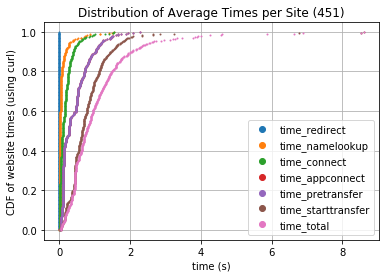

In [46]:
f, ax = subplots()

for col in time_cols:
    xd, yd = getCDF(df_avg_time[col])
    ax.plot(xd, yd, label=col, marker='.', alpha=1, markersize=2, linestyle='None')
    
ax.grid(True)
ax.legend(loc='best', markerscale=6)
ax.set_xlabel("time (s)")
ax.set_ylabel("CDF of website times (using curl)")
ax.set_title("Distribution of Average Times per Site (451)")
f.savefig("results/cdf_avg_time_curl")

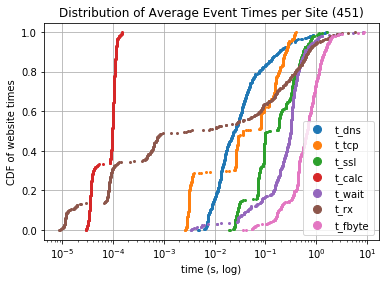

In [54]:
f, ax = subplots()

for col in t_cols:
    xd, yd = getCDF(df_avg_time[col])
    ax.semilogx(xd, yd, label=col, marker='o', markersize=2, alpha=1, linestyle='None')
    
ax.grid(True)
ax.legend(loc='best', markerscale=4)
ax.set_xlabel("time (s, log)")
ax.set_ylabel("CDF of website times")
ax.set_title("Distribution of Average Event Times per Site (451)")
f.savefig("results/cdf_avg_time_diff_calculated")

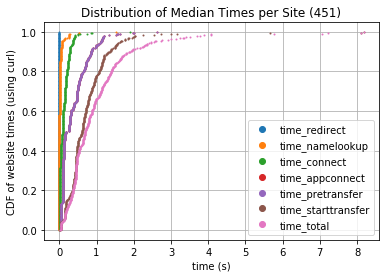

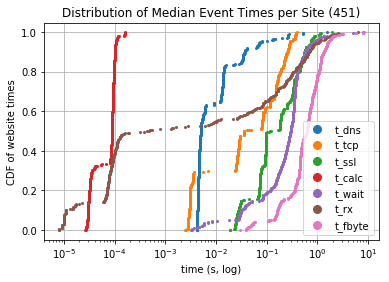

In [53]:
df_median_time = df_pass.groupby(['rank'])[t_cols+time_cols].median()
f, ax = subplots()
for col in time_cols:
    xd, yd = getCDF(df_median_time[col])
    ax.plot(xd, yd, label=col, marker='.', alpha=1, markersize=2, linestyle="None")
ax.grid(True)
ax.legend(loc='best', markerscale=6)
ax.set_xlabel("time (s)")
ax.set_ylabel("CDF of website times (using curl)")
ax.set_title("Distribution of Median Times per Site (451)")
f.savefig("results/cdf_median_time_curl")

f, ax = subplots()
for col in t_cols:
    xd, yd = getCDF(df_median_time[col])
    ax.semilogx(xd, yd, label=col, marker='o', markersize=2, alpha=1, linestyle='None') 
ax.grid(True)
ax.legend(loc='best', markerscale=4)
ax.set_xlabel("time (s, log)")
ax.set_ylabel("CDF of website times")
ax.set_title("Distribution of Median Event Times per Site (451)")
f.savefig("results/cdf_median_time_diff_calculated")

## Min and Max times and websites
- worst performers rank 128, 354, 259, 262, 9, 42, 490, 116
- 128: 'babytree.com': time_appconnect = t_dns + t_tcp + t_ssl
- 354: 'youku.com': 
- 259: 'bestbuy.com'
- 262: 'washingtonpost.com'
- 9: 'taobao.com'
- 42: 'alipay.com'
- 490: 'ilovepdf.com'-
- 116: 'rakuten.co.jp'

In [160]:
df_avg_time.idxmax()

time_redirect           1
time_namelookup       116
time_connect          116
time_appconnect       128
time_pretransfer      128
time_starttransfer    259
time_total            259
t_dns                 116
t_tcp                  42
t_ssl                   9
t_calc                490
t_wait                262
t_rx                  354
t_fbyte               259
dtype: int64

In [183]:
bad_site_ranks = list( set( list( df_avg_time.idxmax() )[1:] ) )
good_site_ranks = list( set( list( df_avg_time.idxmin() )[1:] ) )
#print( bad_site_ranks )
print( {r: rank_to_site[r] for r in bad_site_ranks} )
print( {r: rank_to_site[r] for r in good_site_ranks} )

{128: 'babytree.com', 354: 'youku.com', 259: 'bestbuy.com', 262: 'washingtonpost.com', 9: 'taobao.com', 42: 'alipay.com', 490: 'ilovepdf.com', 116: 'rakuten.co.jp'}
{2: 'youtube.com', 452: 'investing.com', 14: 'live.com', 369: 'elpais.com', 125: 'soundcloud.com', 415: 'chinadaily.com.cn'}


In [165]:
df_avg_time[time_cols + t_cols].describe()

,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
count,451.0,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000
mean,0.0,0.080792,0.176625,0.418919,0.419000,0.801196,1.046710,0.080792,0.095833,0.242294,0.000081,0.382196,0.245514,0.801196
std,0.0,0.184207,0.220120,0.401601,0.401590,0.770926,1.026677,0.184207,0.102714,0.240350,0.000033,0.658629,0.550331,0.770926
min,0.0,0.004685,0.009554,0.033102,0.033191,0.036577,0.036586,0.004685,0.002588,0.019038,0.000029,0.003363,0.000009,0.036577
25%,0.0,0.012776,0.036704,0.112098,0.112204,0.435217,0.442599,0.012776,0.003560,0.072397,0.000037,0.170302,0.000085,0.435217
50%,0.0,0.024512,0.101711,0.279313,0.279412,0.650975,0.770523,0.024512,0.036027,0.118275,0.000097,0.315868,0.002943,0.650975
75%,0.0,0.053229,0.237762,0.605351,0.605477,0.996263,1.337812,0.053229,0.161303,0.347192,0.000105,0.403037,0.258839,0.996263
max,0.0,1.555392,1.558288,2.289830,2.289867,8.597790,8.598477,1.555392,0.400465,1.634377,0.000151,8.469223,5.918629,8.597790


In [302]:
df_avg_time[t_cols].loc[ list( set( list( df_avg_time.idxmax() )[1:] ) ) ]

,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
rank,,,,,,,
128,1.156701,0.369613,0.763516,0.000037,0.369301,0.000085,2.659168
354,0.116848,0.128758,0.332961,0.000137,0.139284,5.918629,0.717989
259,0.030386,0.026264,0.078506,0.000109,8.462525,0.000687,8.597790
262,0.017274,0.002752,0.027246,0.000099,8.469223,0.000011,8.516593
9,0.226125,0.027564,1.634377,0.000035,0.027441,0.000078,1.915543
42,0.133390,0.400465,1.122290,0.000034,0.403038,0.463501,2.059218
490,0.007707,0.082531,0.185237,0.000151,0.417468,0.029055,0.693094
116,1.555392,0.002896,0.031132,0.000029,5.187276,0.098951,6.776726


In [303]:
df_avg_time[time_cols].loc[ list( set( list( df_avg_time.idxmax() )[1:] ) ) ]

,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total
rank,,,,,,,
128,0.0,1.156701,1.526313,2.289830,2.289867,2.659168,2.659252
354,0.0,0.116848,0.245607,0.578568,0.578705,0.717989,6.636618
259,0.0,0.030386,0.056650,0.135156,0.135265,8.597790,8.598477
262,0.0,0.017274,0.020025,0.047271,0.047370,8.516593,8.516605
9,0.0,0.226125,0.253689,1.888066,1.888102,1.915543,1.915620
42,0.0,0.133390,0.533856,1.656146,1.656180,2.059218,2.522719
490,0.0,0.007707,0.090238,0.275475,0.275626,0.693094,0.722149
116,0.0,1.555392,1.558288,1.589420,1.589449,6.776726,6.875676


## find std of columns
- rank 51 has very high std values
- rank 232 has very large std in total_time
- rank 116 has very large std in starttransfer
- all three showed 1/2 patterns- requests with low time followed by high time.

Use df_pass.groupby(['rank'])[cols].std().idxmax()

- 51: naver.com: t_dns was very high for 1/2 requests - major contributor to large time_total and t_fbyte.
- 116: rakuten.co.jp: t_wait was consistently high and t_dns was high for half the requests
- 232: kompas.com: t_rx was high for half the requests

In [83]:
df_pass.groupby(['rank'])[time_cols+t_cols].std().loc[51]

time_redirect         0.000000
time_namelookup       1.713474
time_connect          1.713653
time_appconnect       1.714092
time_pretransfer      1.714095
time_starttransfer    1.713967
time_total            1.723406
t_dns                 1.713474
t_tcp                 0.000756
t_ssl                 0.002294
t_calc                0.000026
t_wait                0.017341
t_rx                  0.059881
t_fbyte               1.713967
Name: 51, dtype: float64

In [84]:
df_pass.groupby(['rank'])[time_cols+t_cols].std().loc[116]

time_redirect         0.000000
time_namelookup       1.707225
time_connect          1.707266
time_appconnect       1.707463
time_pretransfer      1.707463
time_starttransfer    1.763179
time_total            1.765060
t_dns                 1.707225
t_tcp                 0.000384
t_ssl                 0.002269
t_calc                0.000006
t_wait                0.250384
t_rx                  0.027992
t_fbyte               1.763179
Name: 116, dtype: float64

In [85]:
df_pass.groupby(['rank'])[time_cols+t_cols].std().loc[232]

time_redirect         0.000000
time_namelookup       0.239499
time_connect          0.239253
time_appconnect       0.239677
time_pretransfer      0.239680
time_starttransfer    0.256667
time_total            3.456811
t_dns                 0.239499
t_tcp                 0.005778
t_ssl                 0.011885
t_calc                0.000030
t_wait                0.070943
t_rx                  3.450482
t_fbyte               0.256667
Name: 232, dtype: float64

['naver.com', 'rakuten.co.jp', 'kompas.com']


Text(0.5, 1.0, 'response code')

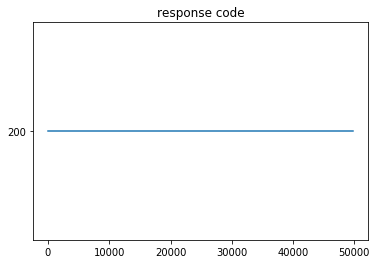

In [86]:
print([rank_to_site[r] for r in [51,116,232]])

plot( df_pass[ df_pass['rank'].isin([51,116,232]) ]['response_code'] )
title('response code')

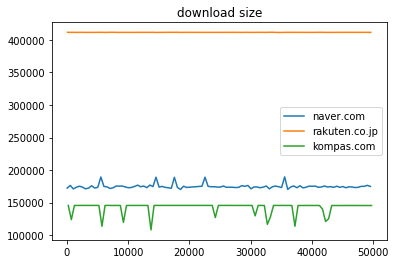

In [87]:
temp = df_pass[ df_pass['rank'].isin([51,116,232]) ][['rank','size_download']].groupby('rank')

for i, val in temp:
    plot(val['size_download'], label=rank_to_site[i])
title('download size')
legend(loc='best')

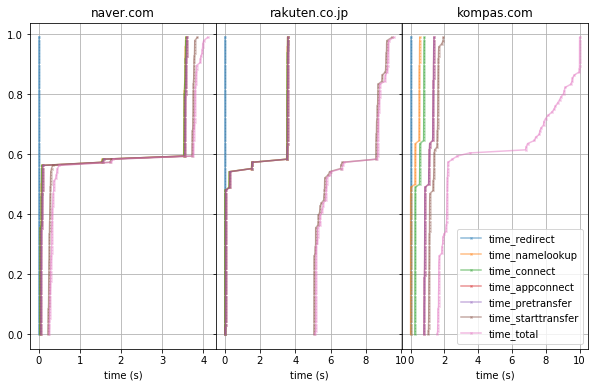

In [88]:
f, axarr = subplots(1,3, sharey=True, figsize=(10,6))
i = 0
for rank in [51, 116, 232]:
    df_observe = df_pass[ df_pass['rank']==rank ]
    for col in time_cols:
        xd, yd = getCDF(df_observe[col])
        axarr[i].plot(xd, yd, label=col, marker='x', alpha=.5, markersize=2)
    axarr[i].grid(True)
    #
    axarr[i].set_xlabel("time (s)")
    #axarr[i].set_ylabel("CDF of website times (using curl)")
    axarr[i].set_title(rank_to_site[rank])
    i+=1

axarr[2].legend(loc='best')
f.subplots_adjust(hspace=0, wspace=0)
f.savefig("results/cdf_time_curl_3sites")

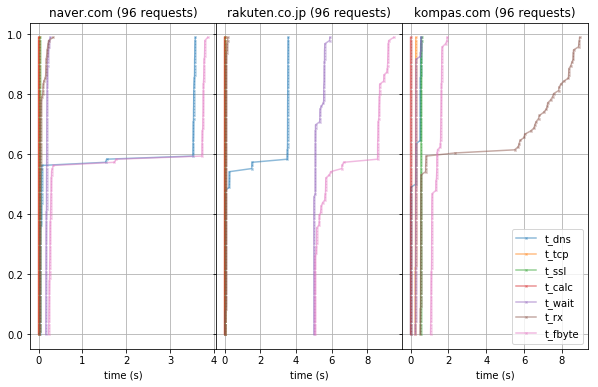

In [89]:
f, axarr = subplots(1,3, sharey=True, figsize=(10,6))
i = 0
for rank in [51, 116, 232]:
    df_observe = df_pass[ df_pass['rank']==rank ]
    for col in t_cols:
        xd, yd = getCDF(df_observe[col])
        axarr[i].plot(xd, yd, label=col, marker='x', alpha=.5, markersize=2)
    axarr[i].grid(True)
    #
    axarr[i].set_xlabel("time (s)")
    #axarr[i].set_ylabel("CDF of website times (using curl)")
    axarr[i].set_title(rank_to_site[rank]+" ("+str(len(df_observe))+" requests)")
    i+=1

axarr[2].legend(loc='best')
f.subplots_adjust(hspace=0, wspace=0)
f.savefig("results/cdf_time_diff_calculated_3sites")

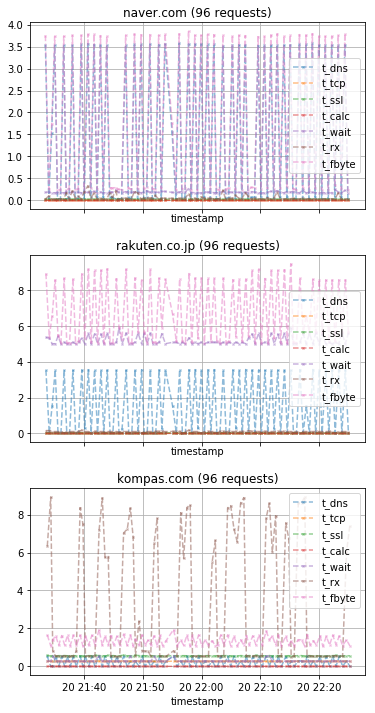

In [91]:
# time vs t_dns for rank 51; t_dns for rank 116; t_rx for 232

f, axarr = subplots(3,1, sharex=True, figsize=(6,12))
i = 0
for rank in [51, 116, 232]:
    df_observe = df_pass[ df_pass['rank']==rank ]
    xd = pd.to_datetime(df_observe.timestamp, unit="s")

    for col in t_cols:
        yd = df_observe[col]
        axarr[i].plot(xd, yd, label=col, marker='x', alpha=.5, linestyle='--', markersize=2)
    #axarr[i].plot(xd, df_observe['t_fbyte'], label='t_fbyte', marker='o', alpha=.5, linestyle='None', markersize=2)
    
    axarr[i].grid(True)
    axarr[i].set_xlabel("timestamp")
    #axarr[i].set_ylabel("CDF of website times (using curl)")
    axarr[i].legend(loc='best')
    axarr[i].set_title(rank_to_site[rank]+" ("+str(len(df_observe))+" requests)")
    i+=1

f.subplots_adjust(hspace=.25, wspace=0)
f.savefig("results/timeseries_3sites_dns_rx_time")

### stacked plot for avg time calculated

In [92]:
df = df_avg_time[t_cols[:6]].copy()
df['site'] = df.index.map(rank_to_site)

0 len 24


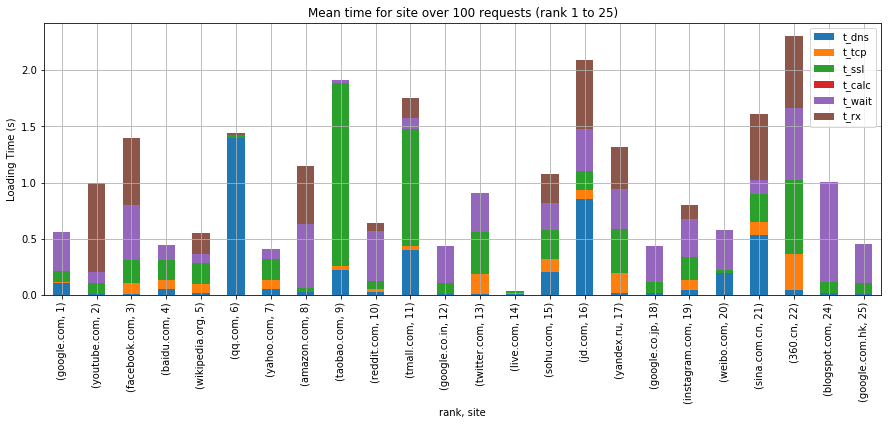

25 len 22


<Figure size 432x288 with 0 Axes>

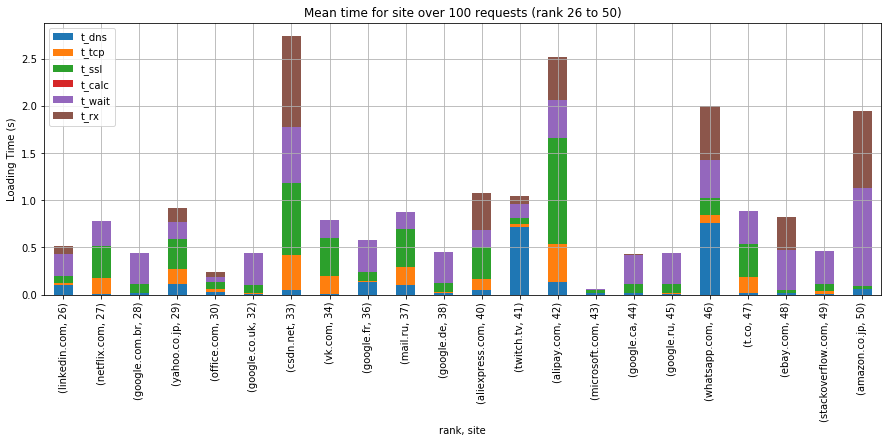

50 len 21


<Figure size 432x288 with 0 Axes>

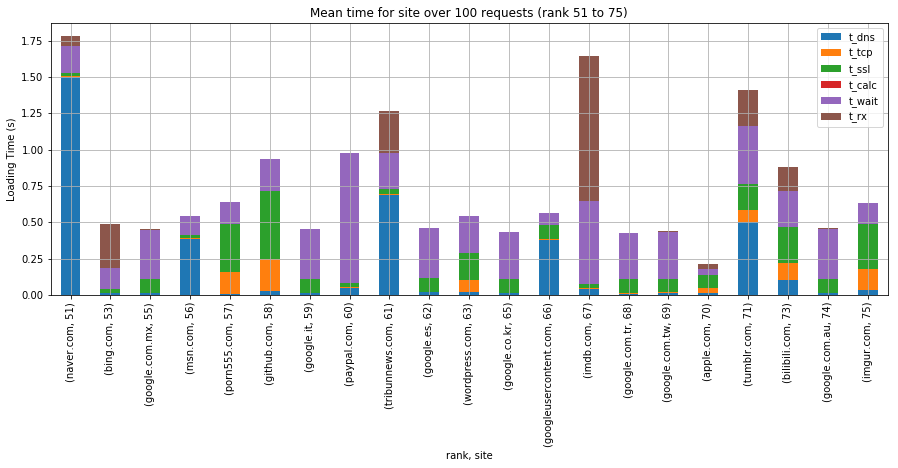

75 len 22


<Figure size 432x288 with 0 Axes>

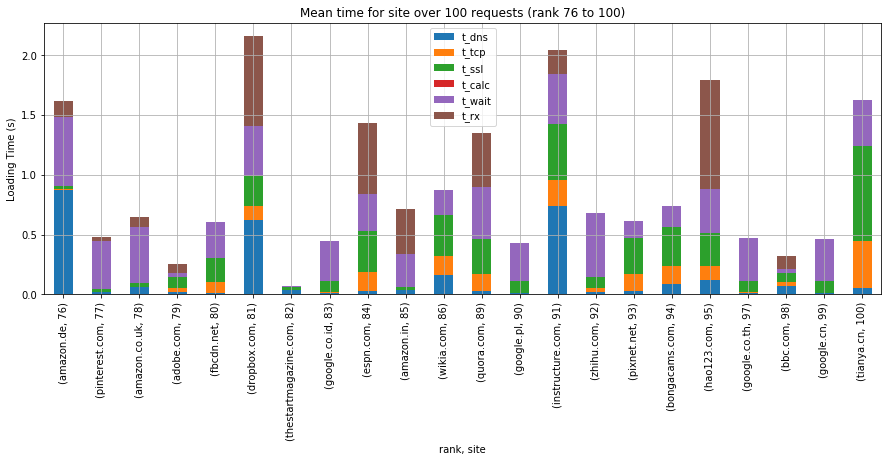

100 len 22


<Figure size 432x288 with 0 Axes>

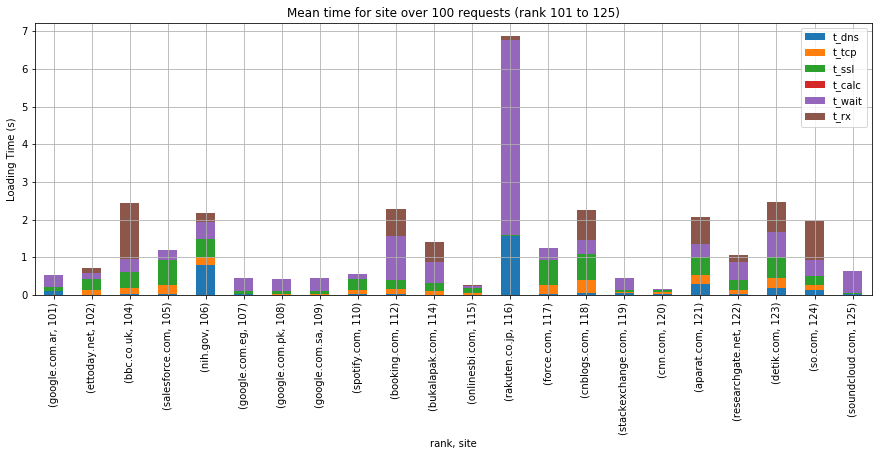

125 len 24


<Figure size 432x288 with 0 Axes>

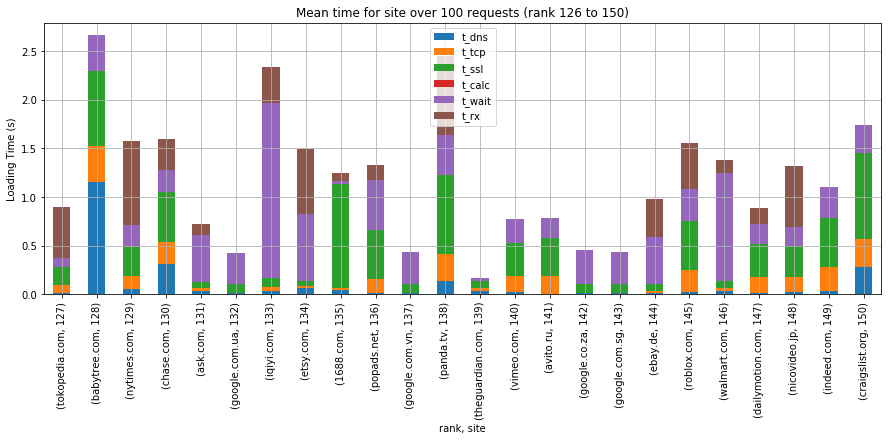

150 len 22


<Figure size 432x288 with 0 Axes>

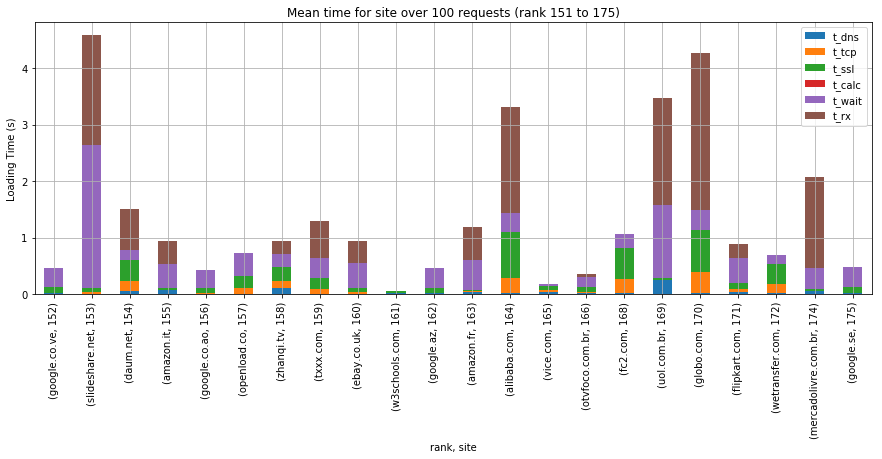

175 len 22


<Figure size 432x288 with 0 Axes>

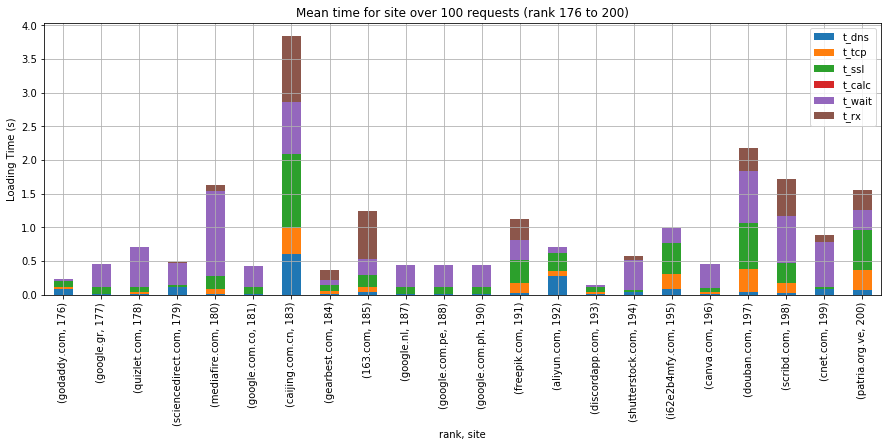

200 len 24


<Figure size 432x288 with 0 Axes>

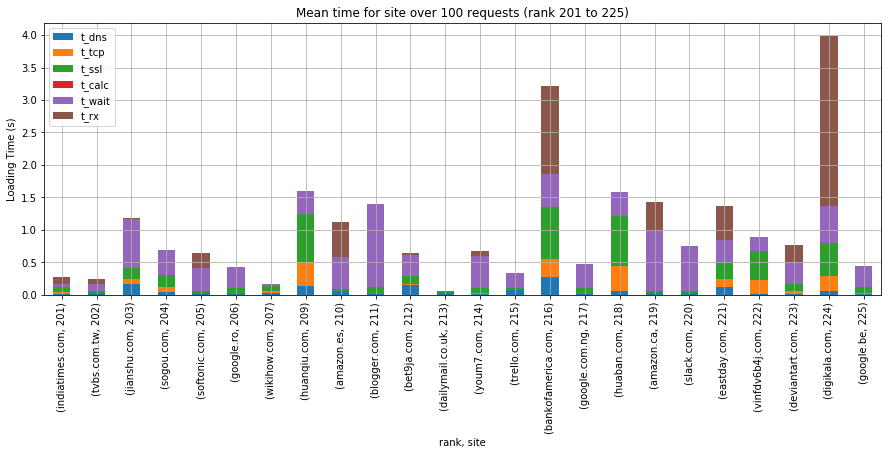

225 len 22


<Figure size 432x288 with 0 Axes>

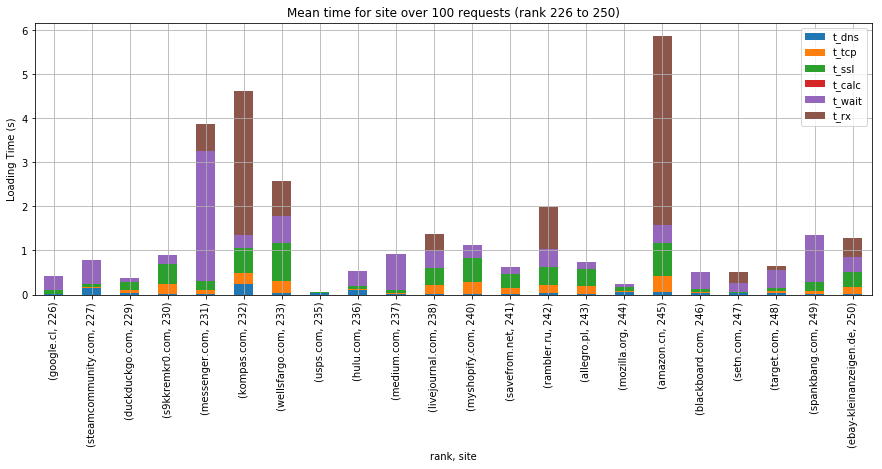

250 len 23


<Figure size 432x288 with 0 Axes>

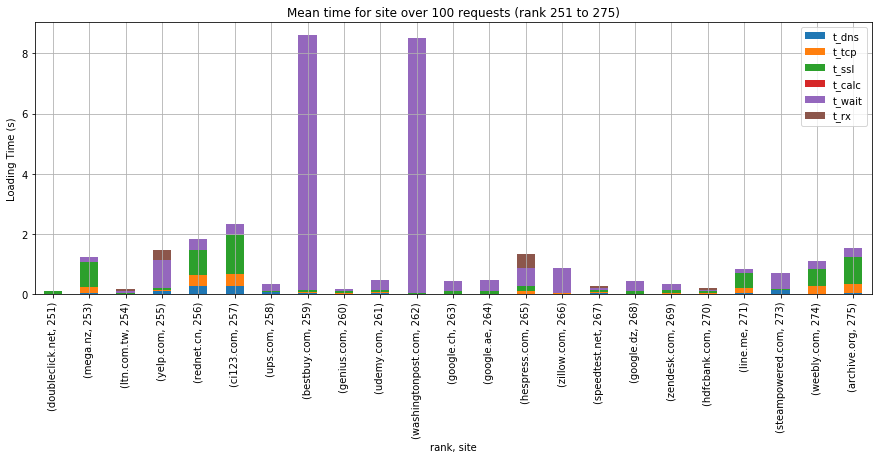

275 len 22


<Figure size 432x288 with 0 Axes>

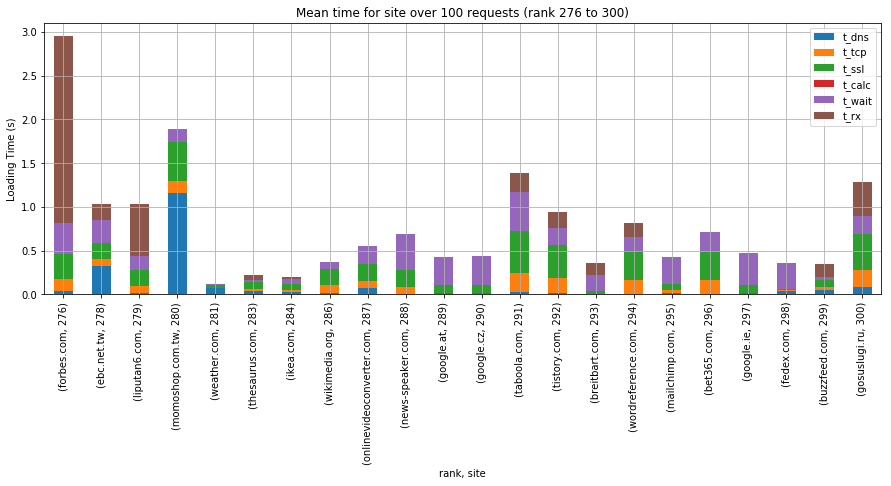

300 len 22


<Figure size 432x288 with 0 Axes>

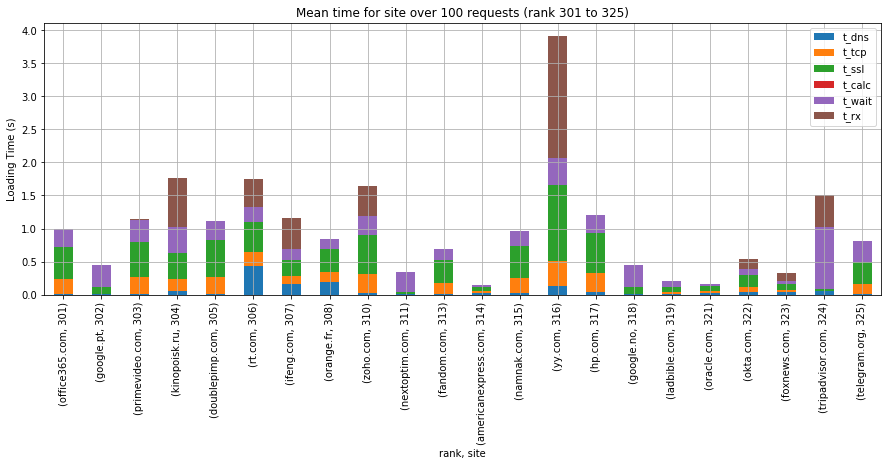

325 len 21


<Figure size 432x288 with 0 Axes>

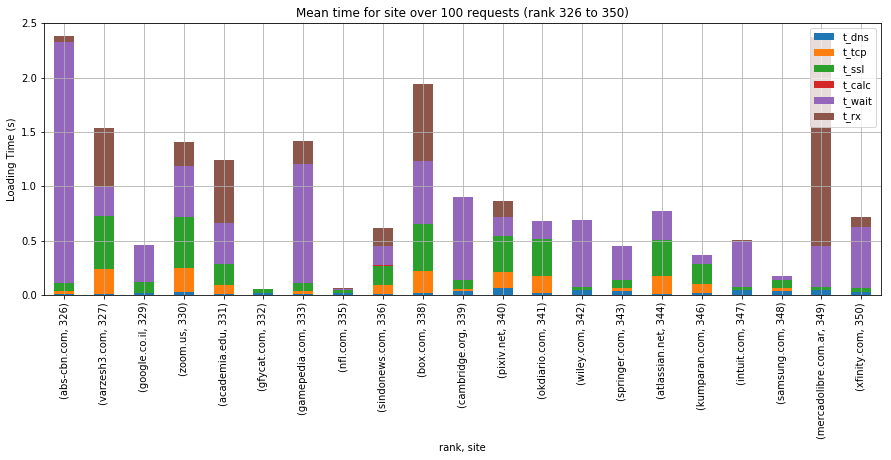

350 len 21


<Figure size 432x288 with 0 Axes>

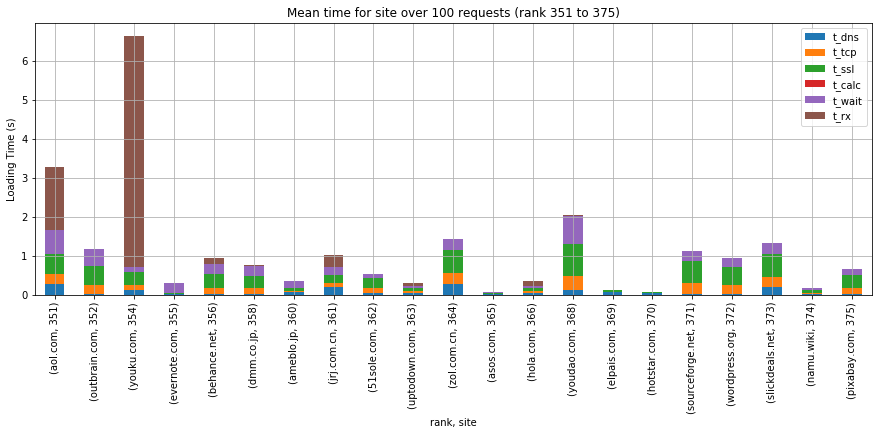

375 len 22


<Figure size 432x288 with 0 Axes>

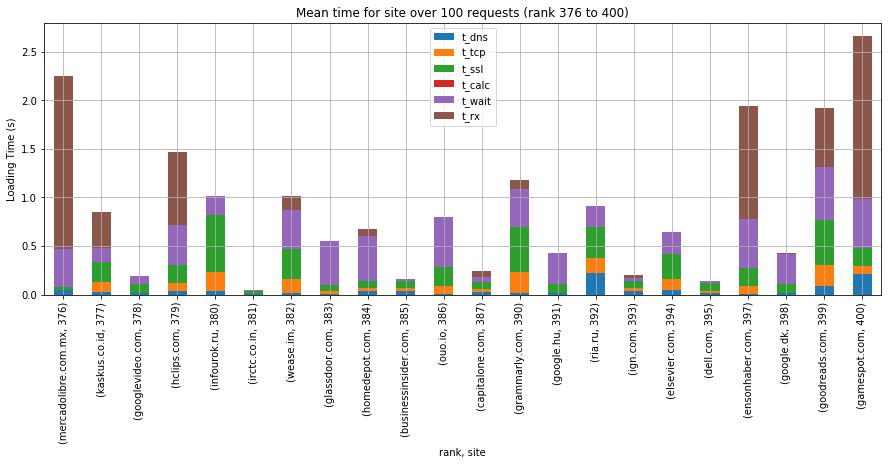

400 len 24


<Figure size 432x288 with 0 Axes>

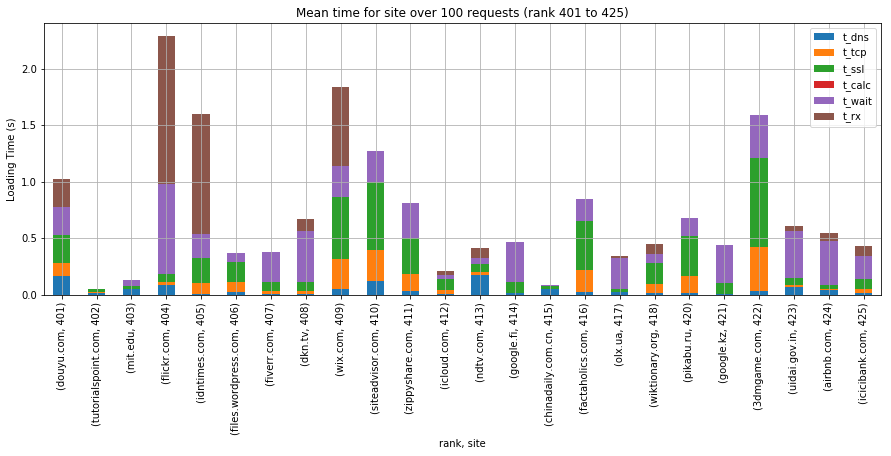

425 len 24


<Figure size 432x288 with 0 Axes>

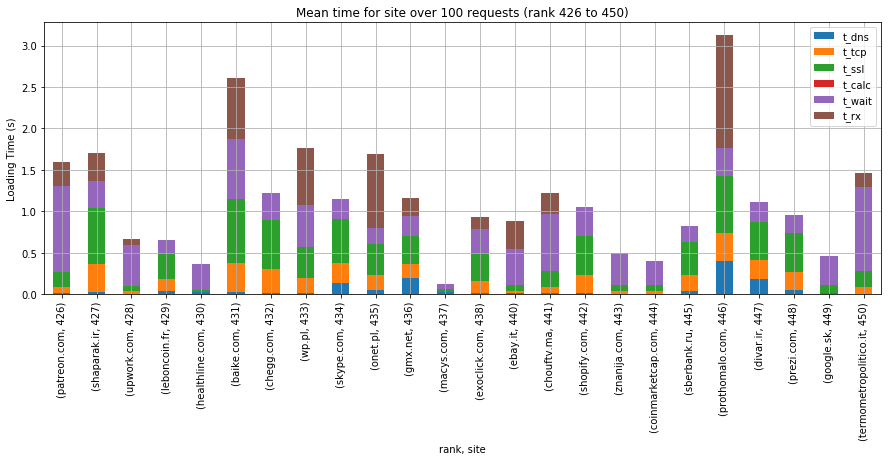

450 len 22


<Figure size 432x288 with 0 Axes>

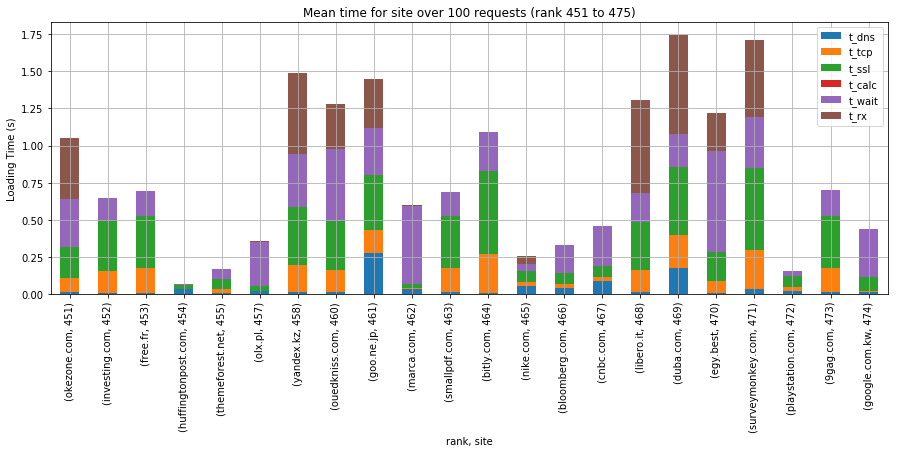

<Figure size 432x288 with 0 Axes>

In [93]:
stp=25
for indx in range(0,len(df),stp):
    df_plot = df.loc[indx+1:indx+stp].reset_index().set_index(["site", "rank"])
    print(indx, "len", len( df_plot ) )
    ax = df_plot.plot.bar(stacked=True,figsize=(15,5))
    ax.set_xlabel("rank, site")
    ax.set_ylabel("Loading Time (s)")
    ax.set_title("Mean time for site over 100 requests (rank %s to %s)" %(indx+1, indx+stp))
    ax.grid(True)
    #ax.set_ylim(0,10)
    plt.show()
    plt.savefig('results/stacked_calc_times_per_site_[%s,%s]'%(indx+1, indx+stp))

In [ ]:
#df.plot.bar(stacked=True,figsize=(50,10))

In [ ]:
#rank=1
#df_observe = df_pass[ df_pass['rank']==rank ][['timestamp','t_dns', 't_tcp', 't_ssl', 't_wait', 't_rx']].set_index('timestamp')
#df = df_observe
#df.index = pd.to_datetime(df.index)
#df = df.stack().reset_index()
#df.columns = ['timestamp', 'time_diff', 'value']
#df.set_index('time_diff',append=True)['value'].unstack().plot.bar(stacked=True,figsize=(10,8))
#df.set_index('TYPE',append=True)['VOL'].unstack().plot.bar(stacked=True,figsize=(10,8))

# CDN-Timing Analysis


In [304]:
df_ip_asn = pd.read_pickle('results/df_ip_asn_grouped.pkl')
df_cdn = pd.read_pickle('results/df_cdn_grouped.pkl')

In [186]:
# create CDN to CDN_group hash
cdn_to_cdn_group = {}
gp_temp = df_cdn[["cdn_all", "cdn_grouped"]].groupby("cdn_all")
for cdn, cdn_grp in gp_temp['cdn_grouped'].unique().to_dict().items():
    if len(cdn_grp)!=1:
        print (cdn, cdn_grp)
    else:
        cdn_to_cdn_group[cdn]=cdn_grp[0]

In [187]:
#df_avg_time['site']=df_avg_time.index.map(rank_to_site)

result = df_avg_time.merge(df_cdn, left_index=True, on='rank', how='left')

In [188]:
result.head()

,rank,time_redirect,time_namelookup,time_connect,time_appconnect,time_pretransfer,time_starttransfer,time_total,t_dns,t_tcp,...,t_calc,t_wait,t_rx,t_fbyte,site,cdn,cdn.most_url,cdn.whois,cdn_all,cdn_grouped
0,1,0.0,0.109924,0.113395,0.208808,0.208906,0.557897,0.558349,0.109924,0.003471,...,0.000097,0.348992,0.000452,0.557897,google.com,Google,None,Google,Google,Google
1,2,0.0,0.006364,0.009554,0.104926,0.105030,0.207875,0.995865,0.006364,0.003190,...,0.000103,0.102845,0.787990,0.207875,youtube.com,Google,None,Google,Google,Google
2,3,0.0,0.010999,0.103928,0.308093,0.308185,0.803609,1.393983,0.010999,0.092928,...,0.000092,0.495423,0.590374,0.803609,facebook.com,Facebook,None,Facebook,Facebook,Facebook
3,4,0.0,0.050045,0.132224,0.314754,0.314789,0.444424,0.444517,0.050045,0.082179,...,0.000035,0.129635,0.000093,0.444424,baidu.com,None,None,None,None,NO CDN
4,5,0.0,0.016001,0.099781,0.282663,0.282779,0.366894,0.555198,0.016001,0.083780,...,0.000116,0.084115,0.188304,0.366894,wikipedia.org,None,None,None,None,NO CDN


# Time performance per CDN 
- 2 websites did not have CDN since they were blocked when trying to find IP: googleusercontent.com (rank 66), wixsite.com (rank 485)
- Of 449 remaining sites, 125 were detected not using CDNs. Google, Amazon AWS, Amazon Cloudfront, Cloudflare, Akamai, Fastly, and Alibaba catered a majority of 222 sites. Other majority well known CDNs accounted for 42 sites with some serving just one of Alexa top 500.
- 36 sites were hosting static content on a domain with "cdn" in its name (assumed CDN based on domain name), marked as "CDN domain". While 24 sites hosted most content on a domain that did not match the website or contain the letters "cdn", hence marked as "Unknown".
- 

In [189]:
print(t_cols)
print(time_cols)

['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx', 't_fbyte']
['time_redirect', 'time_namelookup', 'time_connect', 'time_appconnect', 'time_pretransfer', 'time_starttransfer', 'time_total']


# Average performance across websites for major CDN groups

In [190]:
gp = result.groupby(['cdn_all'])
cdn_group_cnt = gp['rank'].count().sort_values(ascending=False)

In [214]:
df_cdn_perf = gp[t_cols].mean()
df_cdn_perf['count'] = gp['site'].count()
df_cdn_perf['cdn_grouped'] = df_cdn_perf.index.map(cdn_to_cdn_group)
df_cdn_perf.head()

,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,count,cdn_grouped
cdn_all,,,,,,,,,
Akamai,0.118530,0.039792,0.113523,0.000074,0.793871,0.037551,1.065791,26,Akamai
Alibaba,0.121144,0.102396,0.567827,0.000095,0.132377,0.437775,0.923838,7,Alibaba
Amazon CloudFront,0.091980,0.081457,0.184537,0.000082,0.490679,0.590401,0.848735,16,Amazon
Amazon Data Services,0.017006,0.082101,0.183638,0.000112,0.082597,0.000097,0.365453,1,Amazon
Amazon Technologies Inc.,0.070072,0.062258,0.146646,0.000079,0.301831,0.332516,0.580886,21,Amazon


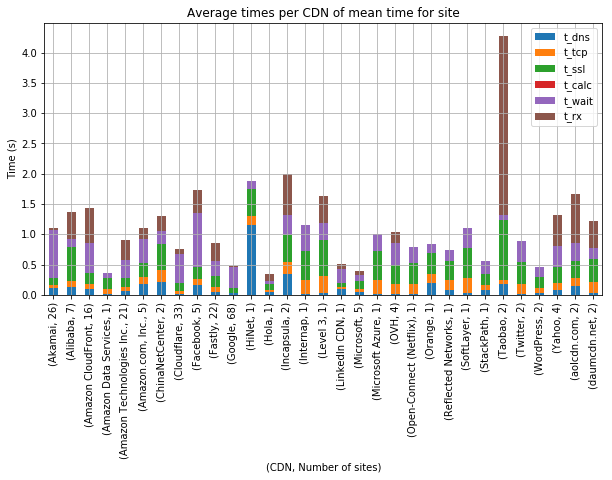

In [192]:
df = df_cdn_perf[ (df_cdn_perf['count']>1) |
                 (df_cdn_perf['cdn_grouped']!="UNKNOWN CDN URL") ].reset_index().set_index(["cdn_all", "count"])

ax = df[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
ax.set_xlabel("(CDN, Number of sites)")
ax.set_ylabel("Time (s)")
ax.set_title("Average times per CDN of mean time for site")
ax.grid(True)
plt.savefig('results/stacked_calc_times_per_cdn')

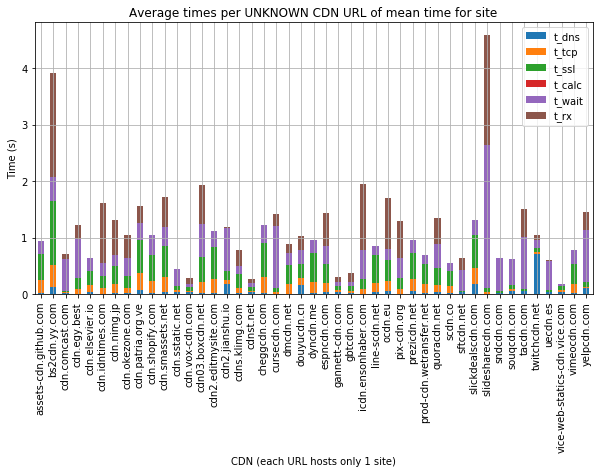

In [193]:
df = df_cdn_perf[ (df_cdn_perf['count']<=1) &
                (df_cdn_perf['cdn_grouped']=="UNKNOWN CDN URL")]

ax = df[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
ax.set_xlabel("CDN (each URL hosts only 1 site)")
ax.set_ylabel("Time (s)")
ax.set_title("Average times per UNKNOWN CDN URL of mean time for site")
ax.grid(True)
plt.savefig('results/stacked_calc_times_per_cdn_only1')

### Grouping CDNs further

In [213]:
gp2 = result.groupby(['cdn_grouped'])
cdn_group_cnt2 = gp2['rank'].count().sort_values(ascending=False)

df_cdn_perf2 = gp2[t_cols].mean()
df_cdn_perf2['count'] = gp2['site'].count()
#df_cdn_perf['cdn_grouped'] = df_cdn_perf.index.map(cdn_to_cdn_group)
df_cdn_perf2

,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,count
cdn_grouped,,,,,,,,
Akamai,0.118530,0.039792,0.113523,0.000074,0.793871,0.037551,1.065791,26
Alibaba,0.132332,0.097010,0.660236,0.000093,0.121485,0.998126,1.011155,9
Amazon,0.089806,0.075067,0.172145,0.000079,0.378765,0.401622,0.715862,43
Cloudflare,0.009976,0.052554,0.128084,0.000107,0.481209,0.080363,0.671929,33
Facebook,0.165870,0.090952,0.200596,0.000102,0.894044,0.385398,1.351563,5
Fastly,0.038930,0.083204,0.185894,0.000096,0.256551,0.288382,0.564675,22
Google,0.022788,0.003502,0.092278,0.000099,0.334015,0.015428,0.452683,68
KNOWN CDN,0.136877,0.156181,0.340923,0.000074,0.264063,0.148497,0.898118,22
Microsoft,0.036718,0.084710,0.191766,0.000078,0.123183,0.059446,0.436455,6


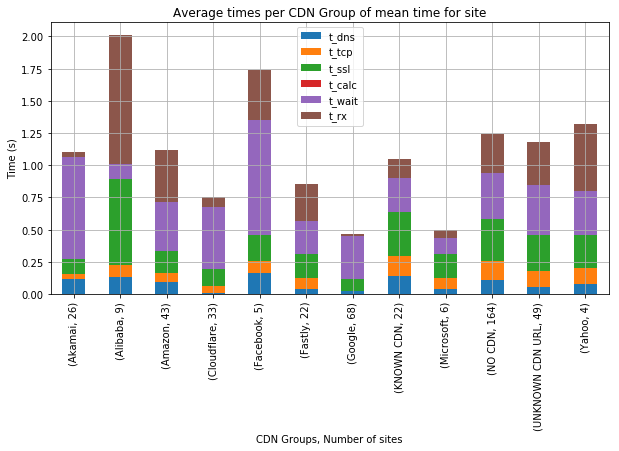

In [200]:
df2 = df_cdn_perf2.reset_index().set_index(["cdn_grouped", "count"])

ax = df2[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(10,5))
ax.set_xlabel("CDN Groups, Number of sites")
ax.set_ylabel("Time (s)")
ax.set_title("Average times per CDN Group of mean time for site")
ax.grid(True)
plt.savefig('results/stacked_calc_times_per_cdn_group')

# Performance across all requests (not sites) for major CDN groups

In [255]:
df_requests = df_pass.merge(df_cdn, on='rank')[["rank", "site", "cdn", "cdn_all", "cdn_grouped"]+t_cols]

In [256]:
gp = df_requests.groupby(['cdn_all'])
cdn_group_cnt = gp['rank'].count().sort_values(ascending=False)

df_cdn_perf = gp[t_cols].mean()
df_cdn_perf['count'] = gp['site'].count()
df_cdn_perf['cdn_grouped'] = df_cdn_perf.index.map(cdn_to_cdn_group)
#df_cdn_perf

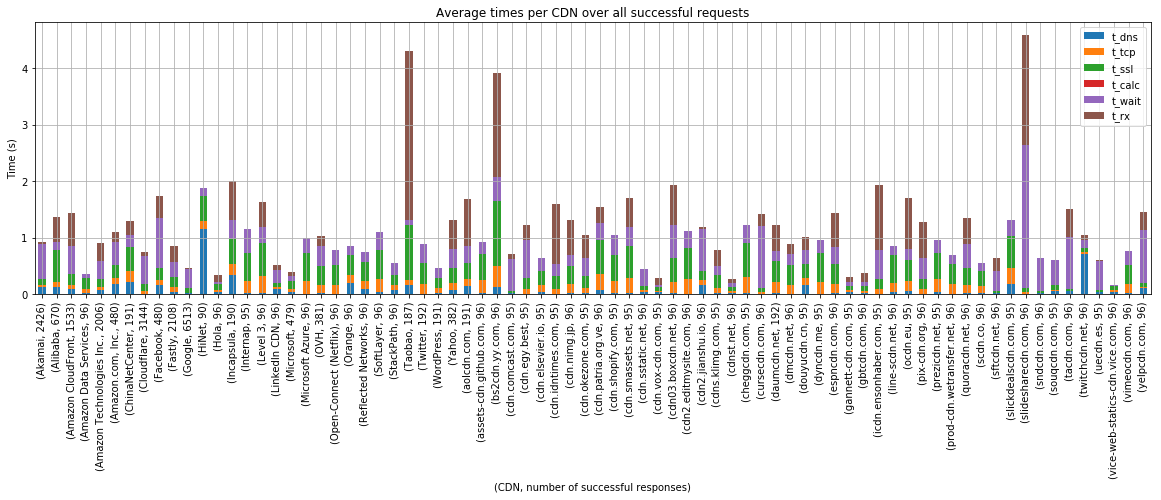

In [257]:
df = df_cdn_perf.reset_index().set_index(["cdn_all", "count"])

ax = df[['t_dns', 't_tcp', 't_ssl', 't_calc', 't_wait', 't_rx']].plot.bar(stacked=True,figsize=(20,5))
ax.set_xlabel("(CDN, number of successful responses)")
ax.set_ylabel("Time (s)")
ax.set_title("Average times per CDN over all successful requests")
ax.grid(True)
plt.savefig('results/stacked_calc_times_per_cdn_all_requests')

In [275]:
df_requests['cdn_flag']=df_requests["cdn_grouped"]!="NO CDN"

#gp3 = result.groupby(['cdn_flag'])
#cdn_group_cnt3 = gp3['rank'].count().sort_values(ascending=False)

df_cdn_perf3 = df_requests[df_requests['cdn_flag']==True][t_cols]
df_nocdn_perf3 = df_requests[df_requests['cdn_flag']==False][t_cols]

df_cdn_perf3.describe().to_html("results/performance_cdn_all_requests.html")
df_cdn_perf3.describe()

,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
count,27382.000000,27382.000000,27382.000000,27382.000000,27382.000000,27382.000000,27382.000000
mean,0.063012,0.069174,0.192573,0.000088,0.378461,0.214628,0.703310
std,0.305705,0.085716,0.213961,0.000040,0.677416,0.609205,0.781758
min,0.004054,0.002081,0.017106,0.000020,0.002640,0.000005,0.027008
25%,0.004213,0.003134,0.071923,0.000073,0.115325,0.000066,0.295417
50%,0.005210,0.027323,0.096432,0.000085,0.271211,0.000489,0.573049
75%,0.014979,0.116267,0.286149,0.000106,0.444686,0.159529,0.865706
max,3.577487,0.477395,4.963809,0.000429,9.049485,9.649226,9.421619


In [276]:
df_nocdn_perf3.describe().to_html("results/performance_noncdn_all_requests.html")
df_nocdn_perf3.describe()

,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
count,15520.000000,15520.000000,15520.000000,15520.000000,15520.000000,15520.000000,15520.000000
mean,0.111156,0.140733,0.324038,0.000069,0.357977,0.302210,0.933973
std,0.400224,0.113035,0.268928,0.000043,0.507265,0.658457,0.807147
min,0.004054,0.002123,0.017145,0.000020,0.002694,0.000005,0.033326
25%,0.004220,0.028721,0.081205,0.000031,0.159837,0.000073,0.443084
50%,0.005464,0.141124,0.305231,0.000059,0.272270,0.056048,0.795595
75%,0.014688,0.216986,0.474759,0.000092,0.390156,0.386729,1.170890
max,4.564151,1.519281,3.945809,0.000626,8.801775,9.323107,9.467070


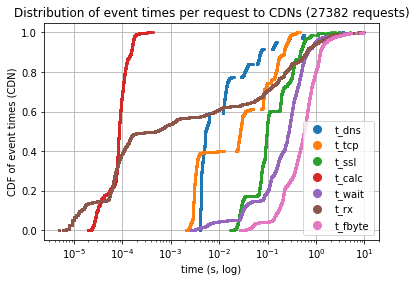

In [260]:
f, ax = subplots()

for col in t_cols:
    xd, yd = getCDF(df_cdn_perf3[col])
    ax.semilogx(xd, yd, label=col, marker='o', markersize=2, alpha=1, linestyle='None')
    
ax.grid(True)
ax.legend(loc='best', markerscale=4)
ax.set_xlabel("time (s, log)")
ax.set_ylabel("CDF of event times (CDN)")
ax.set_title("Distribution of event times per request to CDNs (27382 requests)")
f.savefig("results/cdf_time_diff_by_requests_cdn")

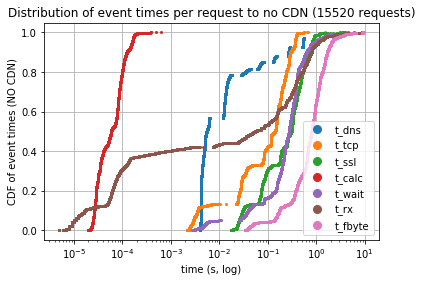

In [261]:
f, ax = subplots()

for col in t_cols:
    xd, yd = getCDF(df_nocdn_perf3[col])
    ax.semilogx(xd, yd, label=col, marker='o', markersize=2, alpha=1, linestyle='None')
    
ax.grid(True)
ax.legend(loc='best', markerscale=4)
ax.set_xlabel("time (s, log)")
ax.set_ylabel("CDF of event times (NO CDN)")
ax.set_title("Distribution of event times per request to no CDN (15520 requests)")
f.savefig("results/cdf_time_diff_by_requests_nocdn")

### QUICK CHECK: separate cdn by parsing and cdn by whois for comparison
- not sure if this makes sense as sites on Fastly, Cloudflare, Incapsula, etc. are counted separate from Akamai, Google, etc. 

In [267]:
df_requests['cdn_parsed_flag']=~( (df_requests['cdn']!=df_requests['cdn_all']) &
                                 (df_requests['cdn_grouped']!="NO CDN") )

df_cdn_perf4 = df_requests[df_requests['cdn_parsed_flag']==True][t_cols]
df_whois_perf4 = df_requests[(df_requests['cdn_parsed_flag']==False) & (df_requests['cdn_flag']==True)][t_cols]
df_nocdn_perf4 = df_requests[df_requests['cdn_flag']==False][t_cols]

In [268]:
df_cdn_perf4.describe()

,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
count,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000,30452.000000
mean,0.089532,0.105297,0.270671,0.000078,0.359167,0.259137,0.824745
std,0.369739,0.109302,0.265003,0.000042,0.446127,0.615575,0.706267
min,0.004054,0.002083,0.017145,0.000020,0.002694,0.000005,0.033326
25%,0.004196,0.003407,0.086861,0.000037,0.156422,0.000069,0.413052
50%,0.005127,0.080848,0.182891,0.000080,0.281066,0.001115,0.668975
75%,0.014457,0.177154,0.391300,0.000099,0.420060,0.305366,1.051792
max,4.564151,1.519281,4.963809,0.000626,8.801775,9.323107,9.467070


In [269]:
df_whois_perf4.describe()

,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
count,12450.000000,12450.000000,12450.000000,12450.000000,12450.000000,12450.000000,12450.000000
mean,0.058162,0.070025,0.165431,0.000089,0.400120,0.214939,0.693828
std,0.268298,0.077819,0.157984,0.000043,0.917819,0.659238,0.983044
min,0.004056,0.002081,0.017106,0.000020,0.002640,0.000005,0.027008
25%,0.004335,0.003896,0.065284,0.000064,0.071704,0.000064,0.195424
50%,0.006104,0.029171,0.080961,0.000085,0.253133,0.005811,0.482378
75%,0.016107,0.116288,0.253891,0.000108,0.392091,0.152837,0.857320
max,3.568970,0.353445,0.777377,0.000429,9.049485,9.649226,9.421619


In [271]:
df_nocdn_perf4.describe()

,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte
count,15520.000000,15520.000000,15520.000000,15520.000000,15520.000000,15520.000000,15520.000000
mean,0.111156,0.140733,0.324038,0.000069,0.357977,0.302210,0.933973
std,0.400224,0.113035,0.268928,0.000043,0.507265,0.658457,0.807147
min,0.004054,0.002123,0.017145,0.000020,0.002694,0.000005,0.033326
25%,0.004220,0.028721,0.081205,0.000031,0.159837,0.000073,0.443084
50%,0.005464,0.141124,0.305231,0.000059,0.272270,0.056048,0.795595
75%,0.014688,0.216986,0.474759,0.000092,0.390156,0.386729,1.170890
max,4.564151,1.519281,3.945809,0.000626,8.801775,9.323107,9.467070


# Detailed CDN-ASN grouped analysis vs NO CDN
- start by merging ASN and CDN info for all sites

In [307]:
df_cdn_asn = df_cdn.merge(df_ip_asn)


- Google CDN average total time per requests in about 0.4s. Majority delay is wait time (since most responses were redirects, not much data download and low receive time). t_wait - t_tcp can give us an estimate of the server wait. Google CDN has a very large server wait time, in comparison name resolution, tcp handshake, ssl negotiation, and reception time is lesser than server wait time.
    - Non google.* domains: blogger.com and blogspot.com have higher wait times and end up redirecting, while youtube.com has a high receive time possibly due to larger download size.
    - google.* domains have the same behavior (overall 1/3rd returned 200 OK while the rest redirected). Even with much smaller size, the redirected page (response code 302) took an extra 0.3s in wait time compared to the status 200 OK page.
- 46 sites on Amazon AWS have similar performance to 4 sites on Cloudfront, except for higher reception time for sites on AWS. Average total waiting time is 1.127s
    - 10 amazon.* domains with similar performance - either 200 OK page with a 1.5s reception time (2.7s total time), or a 503 server unavailable with 0.7s total time. All on ASN16509 (except amazon.cn)
    - 36 distributed across 2 ASNs with no pattern. Average total_time about 1s. AS14618 and ASN16509.
    - 4 sites on Cloudfront also no particular pattern (07s total time average). Above 2 ASNs, confirming that some websites on Amazon AWS might be using Cloudfront as their CDN.
    - trello.com is on AS16625 (Akamai) but seems to be using majority amazon services on its web page, detecting CDN as Cloudfront even though its on Akamai. It would be best for it to move to Cloudfront if a majority of the resources are loaded from there.
- 29 sites on Akamai, and 4 on Microsoft, have a large server waiting time across sites. Avg total time is .97s, avg waiting time is  0.64s.
    - 2 websites, washingtonpost.com and bestbuy.com, are responsible for increasing the average wait time (each more than 8s). While bestbuy at least returned a 200 OK response, washingtonpost only redirected us yet the wait time was the majority of the total time. This is either done intentionally against web scraping scripts, or is possibly a mistake.
    - 3 sites, liputan6.com, naver.com, and asos.com were using Akamai resources for most static objects on their page. Their ASNs do not belong to Akamai but we've considered them as using Akamai due to the external urls to hosted objects in their home pages. 
    - 3 websites, microsoft.com, msn.com, and skype.com are using Microsoft as their CDN which is part of Akamai for Microsoft services (including office.com, office365.com, bing.com, and live.com). Individually, microsoft websites perform much better than their Akamai counterpart. Avg total time for Microsoft is 0.26s (0.56s for live.com on a different ASN). Akamai had a more inconsistent performance with an avg 0.92s total time.
    - ASN16625 has an overall inconsistent performance (especially due to bestbuy.com). Without bestbuy.com, the avg total time is only .33s with wait time .16s.
- 9 sites use Alibaba. Comparison shows that Alibaba CDN (including Taobao sites) have the worst performance across CDNs, especially during SSL negotiation and data received. Average total waiting time is 2s. SSL negotiation time is 0.6s and receive time is almost 1s.
    - Detailed analysis shows 2 ASNs catering to these 8 sites: 45102 (Alibaba) and 37963 (Taobao), both owned by Alibaba CDN.
    - 3 of 5 sites on AS37963 have an average t_ssl (mean t_ssl for site across 100 requests) over 1s.
    - 2 of 4 sites on AS45102 had a very high t_rx (alibaba.com: 1.88s, youku.com: 5.9s). This may be because the size of data downloaded by youku.com on request an order of magnitude higher than the overall average (~1MB).
- 28 sites use Fastly. The average total time is .82s with receive time + wait time accounting for .24s and .26s respectively. All sites were on AS54113
    - rank 10 site reddit.com uses fastly, but most requests to reddit were blocked by the server. Only 5 requests got a 200 OK response. For other sites, either they consistently redirected or consistently gave 200 OK. Server wait time was almost 1.1s regardless of status code.
    - bbc.co.uk, nytimes.com, forbes.com, etsy.com, scribd.com all had relatively high receive time, possibly as they were loading a larger homepage than others.
    - Overall sites returning 200 status OK had a higher ssl, receive and wait time, while redirecting sites had high ssl negotiation

In [288]:
gp2 = result.groupby('cdn_grouped')
cdn_group_cnt = gp2['rank'].count()

In [289]:
cdn_group_cnt

cdn_grouped
Akamai              26
Alibaba              9
Amazon              43
Cloudflare          33
Facebook             5
Fastly              22
Google              68
KNOWN CDN           22
Microsoft            6
NO CDN             164
UNKNOWN CDN URL     49
Yahoo                4
Name: rank, dtype: int64

In [290]:
df2 = gp2[t_cols + ['time_total']].mean()
df2['count'] = gp2['site'].count()
df2['sort_by'] = [4,4,4,4,4,4,4,3,4,1,2,4]
df_cdn_perf2 = df2.sort_values(['sort_by','count'], ascending=False).reset_index().set_index(['cdn_grouped', 'count'])

In [291]:
df_cdn_perf2

,,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,sort_by
cdn_grouped,count,,,,,,,,,
Google,68,0.022788,0.003502,0.092278,0.000099,0.334015,0.015428,0.452683,0.468111,4
Amazon,43,0.089806,0.075067,0.172145,0.000079,0.378765,0.401622,0.715862,1.117485,4
Cloudflare,33,0.009976,0.052554,0.128084,0.000107,0.481209,0.080363,0.671929,0.752292,4
Akamai,26,0.118530,0.039792,0.113523,0.000074,0.793871,0.037551,1.065791,1.103342,4
Fastly,22,0.038930,0.083204,0.185894,0.000096,0.256551,0.288382,0.564675,0.853057,4
Alibaba,9,0.132332,0.097010,0.660236,0.000093,0.121485,0.998126,1.011155,2.009281,4
Microsoft,6,0.036718,0.084710,0.191766,0.000078,0.123183,0.059446,0.436455,0.495901,4
Facebook,5,0.165870,0.090952,0.200596,0.000102,0.894044,0.385398,1.351563,1.736962,4
Yahoo,4,0.079197,0.120714,0.261782,0.000089,0.336962,0.522172,0.798746,1.320918,4


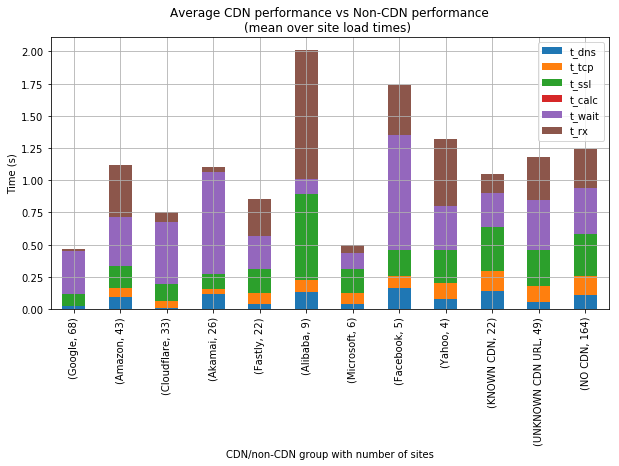

In [309]:
ax = df_cdn_perf2[t_cols[:6]].plot.bar(stacked=True,figsize=(10,5))
ax.set_xlabel("CDN/non-CDN group with number of sites")
ax.set_ylabel("Time (s)")
ax.set_title("Average CDN performance vs Non-CDN performance\n(mean over site load times) ")
ax.grid(True)
plt.savefig('results/stacked_calc_times_per_cdn_vs_noncdn')

In [310]:
def stack_bar_time_plot(df):
    ax = df[t_cols[:6]].plot.bar(stacked=True,figsize=(10,5))
    ax.set_ylabel("Time (s)")
    ax.grid(True)
    return ax

## Individual group analysis for CDN and ASN

#### Google

In [319]:
site_cdn_ranks = [r for r,s in rank_to_site.items() if 'google.' in s]
print(site_cdn_ranks)
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['response_code'])
#gp_check['timestamp'].count()
df = gp_check[t_cols + ['time_total', 'size_download']].mean()
df

[1, 12, 18, 25, 28, 32, 36, 38, 44, 45, 55, 59, 62, 65, 68, 69, 74, 83, 90, 97, 99, 101, 107, 108, 109, 132, 137, 142, 143, 152, 156, 162, 175, 177, 181, 187, 188, 190, 206, 217, 225, 226, 263, 264, 268, 289, 290, 297, 302, 318, 329, 391, 398, 414, 421, 449, 474]


,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,size_download
response_code,,,,,,,,,
200,0.023962,0.003097,0.095911,0.000098,0.119084,0.001555,0.242152,0.243707,14930.730167
302,0.015131,0.003146,0.095404,0.000098,0.448986,0.000085,0.562765,0.562850,327.804513


In [338]:
gp_check_google = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['response_code'])
#gp_check['timestamp'].count()
df_google = gp_check_google[t_cols + ['time_total', 'size_download']].mean().reset_index()
df_google["site"] = ["google.*", "google.*"]
df_google["asn"] = [15169, 15169]
#df_google = df_google.merge(df_cdn_asn, on='rank')
#df_google

In [339]:
site_cdn_ranks2 = list( result[result['cdn_grouped']=='Google']['rank'] )
site_cdn_ranks3 = [x for x in site_cdn_ranks2 if x not in site_cdn_ranks]
print(site_cdn_ranks3)
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks3) ].groupby(['rank','response_code'])
#gp_check['timestamp'].count()
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_cdn_asn, on='rank')

[2, 24, 66, 211, 251, 293, 311, 355, 378, 384, 488]


/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


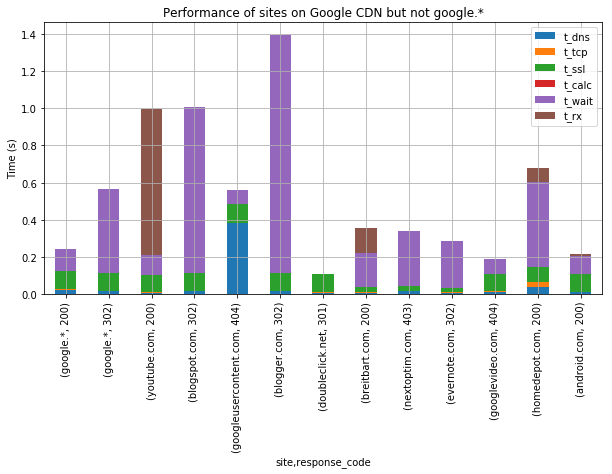

In [341]:
df_google_compare = pd.concat([df_google, df])

ax = stack_bar_time_plot(df_google_compare.set_index(['site', 'response_code']))
ax.set_title("Performance of sites on Google CDN but not google.*")
plt.savefig("results/stacked_calc_times_per_site_nongoogle")

#### Amazon


In [342]:
site_cdn_ranks = [r for r,s in rank_to_site.items() if 'amazon.' in s]
print(site_cdn_ranks)
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['response_code'])
df = gp_check[t_cols + ['time_total', 'size_download']].mean()
df

[8, 50, 76, 78, 85, 155, 163, 210, 219, 245]


,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,size_download
response_code,,,,,,,,,
200,0.077595,0.064855,0.151913,0.000083,0.663519,1.515899,0.957964,2.473863,183466.665385
503,0.190517,0.009939,0.041107,0.000092,0.464645,0.000099,0.706302,0.706401,4003.029545


In [343]:
#df_asn_cdn[ df_asn_cdn['rank'].isin(site_cdn_ranks3) ]

[67, 91, 106, 168, 174, 179, 202, 215, 220, 223, 247, 266, 291, 299, 303, 322, 330, 332, 344, 346, 349, 370, 376, 390, 393, 399, 417, 424, 430, 457, 463, 464, 481]


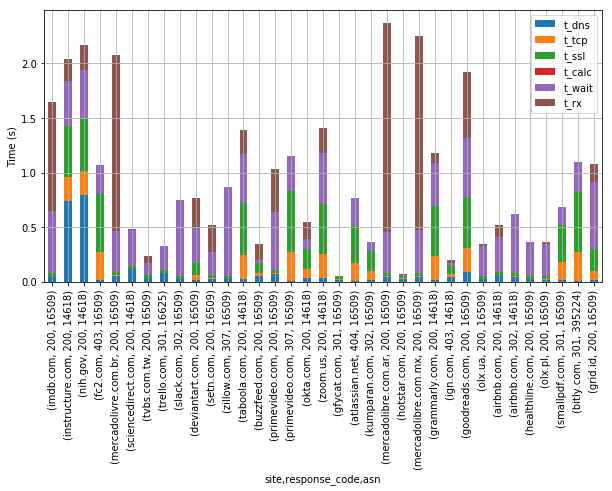

In [346]:
site_cdn_ranks2 = list( result[result['cdn_grouped']=='Amazon']['rank'] )
site_cdn_ranks3 = [x for x in site_cdn_ranks2 if x not in site_cdn_ranks]
print(site_cdn_ranks3)
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks3) ].groupby(['rank','response_code'])
#gp_check['timestamp'].count()
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_cdn_asn, on='rank')
#df

ax = stack_bar_time_plot(df.set_index(['site', 'response_code', 'asn']))
plt.savefig("results/stacked_calc_times_per_site_nonamazon")

In [347]:
site_cdn_ranks = result[ result['cdn_all']=='Amazon CloudFront' ]['rank']
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['rank', 'response_code'])
gp_check['timestamp'].count()
#gp_check[t_cols + ['size_download']].mean().reset_index().merge(df_asn_cdn, on='rank')

rank  response_code
8     200              43
      503              53
50    200              87
      503               9
67    200              96
76    200              19
      503              77
78    200              17
      503              79
85    200              69
      503              27
155   200              35
      503              61
163   200              51
      503              45
210   200              51
      503              45
215   301              96
219   200              60
      503              36
245   200              88
      503               8
303   200               4
      307              92
330   200              95
344   404              95
464   301              95
Name: timestamp, dtype: int64

#### Akamai

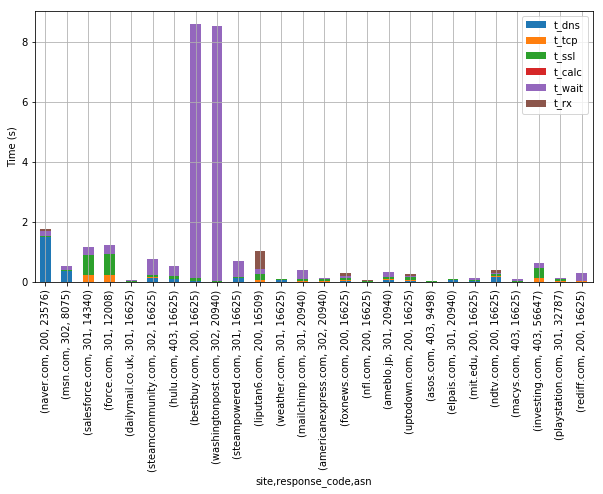

In [348]:
site_cdn_ranks = result[ result['cdn_grouped']=='Akamai' ]['rank']
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['rank', 'response_code'])
#gp_check['timestamp'].count()
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_cdn_asn, on='rank')

ax = stack_bar_time_plot(df.set_index(['site', 'response_code', 'asn']))
plt.savefig("results/stacked_calc_times_per_site_akamai")

In [357]:
site_cdn_ranks = result[ result['cdn_grouped']=='Akamai' ]['rank']
gp_check = df_pass[ (df_pass['rank'].isin(site_cdn_ranks)) &
                   (df_pass['rank']!=259) ].merge(df_cdn_asn[['asn','rank']], on='rank').groupby(['asn'])
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index()
df

,asn,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,size_download
0,12008,0.012255,0.243282,0.678671,0.000038,0.312284,0.000011,1.246531,1.246543,0.000000e+00
1,14340,0.016254,0.242549,0.664242,0.000037,0.262158,0.000010,1.185239,1.185249,0.000000e+00
2,16509,0.014098,0.082115,0.183100,0.000100,0.162658,0.589599,0.442070,1.031669,1.045178e+06
3,16625,0.072457,0.014221,0.048938,0.000068,0.161904,0.026658,0.297588,0.324246,8.789544e+04
4,20940,0.044124,0.017786,0.057253,0.000075,1.343933,0.000056,1.463171,1.463227,1.290538e+02
5,23576,1.500233,0.002963,0.025472,0.000099,0.187175,0.065178,1.715942,1.781120,1.748088e+05
6,32787,0.022765,0.026478,0.073273,0.000106,0.032106,0.000011,0.154728,0.154739,0.000000e+00
7,56647,0.004685,0.150730,0.335569,0.000033,0.152869,0.000076,0.643886,0.643962,2.908842e+02
8,8075,0.386441,0.002714,0.024608,0.000104,0.131234,0.000110,0.545102,0.545212,1.430000e+02
9,9498,0.013755,0.002871,0.024545,0.000094,0.019456,0.000080,0.060721,0.060801,2.620000e+02


In [355]:
d = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].merge(df_cdn_asn[['asn','rank']], on='rank')
d[ d['asn'].isin(["16625"]) ].mean()

response_code                  inf
size_request          7.795148e+01
size_upload           0.000000e+00
size_download         8.323656e+04
size_header           4.328701e+02
time_redirect         0.000000e+00
time_namelookup       7.003471e-02
time_connect          8.494941e-02
time_appconnect       1.355899e-01
time_pretransfer      1.356605e-01
time_starttransfer    7.753960e-01
time_total            8.005589e-01
rank                  3.274367e+02
timestamp             1.545343e+09
size_up               7.795148e+01
size_dw               8.366943e+04
t_dns                 7.003471e-02
t_tcp                 1.491470e-02
t_ssl                 5.064052e-02
ssl_flag              1.000000e+00
t_calc                7.058388e-05
t_wait                6.397355e-01
t_fbyte               7.753960e-01
t_rx                  2.516288e-02
fail                  0.000000e+00
asn                            inf
dtype: float64

#### Alibaba/Taobao

In [358]:
site_cdn_ranks = result[ result['cdn_grouped']=='Alibaba' ]['rank']
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['rank', 'response_code'])
gp_check['timestamp'].count()

rank  response_code
9     302              92
11    200              96
40    200              96
127   200              96
135   200              95
164   200              96
192   302              96
354   200              95
362   404              95
Name: timestamp, dtype: int64

In [359]:
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_cdn_asn, on='rank')
df

,rank,response_code,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,...,site,cdn,cdn.most_url,cdn.whois,cdn_all,cdn_grouped,ip,asn,asname,as_grouped
0,9,302,0.226125,0.027564,1.634377,0.000035,0.027441,0.000078,1.915543,1.915620,...,taobao.com,Taobao,None,Taobao,Taobao,Alibaba,140.205.94.189,37963,CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...,Alibaba
1,11,200,0.403465,0.027723,1.046180,0.000100,0.098006,0.176988,1.575475,1.752463,...,tmall.com,Alibaba,None,Taobao,Alibaba,Alibaba,140.205.130.99,37963,CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...,Alibaba
2,40,200,0.052061,0.118037,0.338859,0.000102,0.172320,0.395000,0.681379,1.076379,...,aliexpress.com,Alibaba,None,Alibaba,Alibaba,Alibaba,198.11.132.250,45102,CNNIC-ALIBABA-CN-NET-AP Alibaba (China) Techno...,Alibaba
3,127,200,0.013479,0.082343,0.187081,0.000106,0.089074,0.521814,0.372082,0.893896,...,tokopedia.com,None,ecs7.tokopedia.net,Alibaba,Alibaba,Alibaba,47.88.159.115,45102,CNNIC-ALIBABA-CN-NET-AP Alibaba (China) Techno...,Alibaba
4,135,200,0.039820,0.027511,1.069523,0.000109,0.029259,0.084358,1.166222,1.250579,...,1688.com,Alibaba,None,Taobao,Alibaba,Alibaba,140.205.174.2,37963,CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...,Alibaba
5,164,200,0.017841,0.262486,0.812662,0.000102,0.332617,1.886106,1.425709,3.311815,...,alibaba.com,Alibaba,None,Alibaba,Alibaba,Alibaba,198.11.132.23,45102,CNNIC-ALIBABA-CN-NET-AP Alibaba (China) Techno...,Alibaba
6,192,302,0.276168,0.081533,0.265356,0.000102,0.085232,0.000089,0.708391,0.708479,...,aliyun.com,Alibaba,None,Taobao,Alibaba,Alibaba,140.205.172.20,37963,CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...,Alibaba
7,354,200,0.116848,0.128758,0.332961,0.000137,0.139284,5.918629,0.717989,6.636618,...,youku.com,None,static.youku.com,Taobao,Taobao,Alibaba,106.11.186.25,37963,CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...,Alibaba
8,362,404,0.045178,0.117138,0.255125,0.000043,0.120128,0.000070,0.537611,0.537681,...,51sole.com,None,None,Alibaba,Alibaba,Alibaba,47.90.2.56,45102,CNNIC-ALIBABA-CN-NET-AP Alibaba (China) Techno...,Alibaba


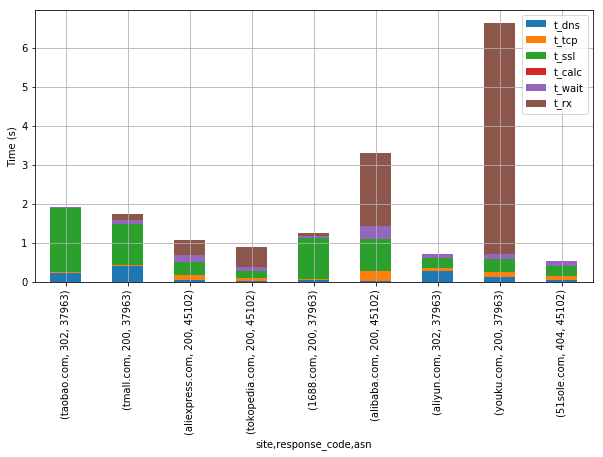

In [360]:
ax = stack_bar_time_plot(df.set_index(['site', 'response_code', 'asn']))
plt.savefig("results/stacked_calc_times_per_site_alibaba")

#### Fastly

In [361]:
site_cdn_ranks = result[ result['cdn_grouped']=='Fastly' ]['rank']
gp_check = df_pass[ df_pass['rank'].isin(site_cdn_ranks) ].groupby(['rank', 'response_code'])
#gp_check['timestamp'].count()

In [362]:
df = gp_check[t_cols + ['time_total', 'size_download']].mean().reset_index().merge(df_cdn_asn, on='rank')
#df

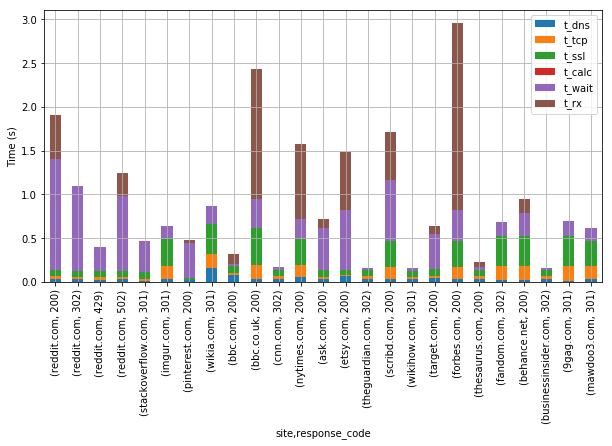

In [363]:
ax = stack_bar_time_plot(df.set_index(['site', 'response_code']))
plt.savefig("results/stacked_calc_times_per_site_fastly")

In [364]:
df.groupby('response_code').mean()

,rank,t_dns,t_tcp,t_ssl,t_calc,t_wait,t_rx,t_fbyte,time_total,size_download
response_code,,,,,,,,,,
200,170.333333,0.038349,0.075864,0.174598,0.000088,0.430869,0.564786,0.719768,1.284554,266751.650347
301,229.333333,0.045927,0.112036,0.240002,0.000105,0.174965,0.000052,0.573035,0.573087,104.166667
302,193.400000,0.031263,0.055173,0.125535,0.000103,0.243798,0.000024,0.455872,0.455896,9.400000
429,10.000000,0.025863,0.028449,0.071476,0.000099,0.267373,0.000086,0.393259,0.393345,1064.014085
502,10.000000,0.028671,0.028129,0.070329,0.000091,0.853360,0.257918,0.980579,1.238497,266414.117647
